In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

Функции нахождения значения S()

In [20]:
def s(a, b, c, d, x):
    """
    Вычисляет значение кубического полинома S в точке x.
    
    Params:
    a, b, c, d - коэффициенты полинома.
    x - значение, в котором нужно вычислить полином.
    
    Return:
    Значение полинома S в точке x.
    """
    return a + b * x + c * x**2 + d * x**3


Функция решения системы

In [21]:
def tridiagonal_solve(A, b):
    """
    Решает систему линейных уравнений с трёхдиагональной матрицей методом прогонки.
    
    Params:
    A - трёхдиагональная матрица коэффициентов системы.
    b - вектор свободных членов.
    
    Return:
    Вектор x, являющийся решением системы Ax = b.
    """
    n = len(A)
    v = [0 for _ in range(n)]
    u = [0 for _ in range(n)]
    
    # Прямой ход метода прогонки
    v[0] = A[0][1] / -A[0][0]
    u[0] = b[0] / A[0][0]
    for i in range(1, n-1):
        v[i] = A[i][2] / (-A[i][1] - A[i][0] * v[i-1])
        u[i] = (A[i][0] * u[i-1] - b[i]) / (-A[i][1] - A[i][0] * v[i-1])
    
    v[n-1] = 0
    u[n-1] = (A[n-1][1] * u[n-2] - b[n-1]) / (-A[n-1][2] - A[n-1][1] * v[n-2])
    
    # Обратный ход метода прогонки
    x = [0 for _ in range(n)]
    x[n-1] = u[n-1]
    for i in range(n-1, 0, -1):
        x[i-1] = v[i-1] * x[i] + u[i-1]

    return x
    

Функция вычисления коэффициентов кубического сплайна

In [22]:
def spline_interpolation(x_i, f_i, x_star):
    """
    Вычисляет значения коэффициентов кубического сплайна и значение сплайна в точке x_star.
    
    Параметры:
    x_i - узлы интерполяции.
    f_i - значения функции в узлах интерполяции.
    x_star - точка, в которой нужно вычислить значение сплайна.
    
    Возвращает:
    Коэффициенты сплайна a, b, c, d и значение сплайна в точке x_star.
    """
    assert len(x_i) == len(f_i)
    n = len(x_i)
    
    # Вычисление шагов h
    h = [x_i[i] - x_i[i - 1] for i in range(1, len(x_i))]
    
    # Инициализация матрицы A для системы уравнений
    A = [[0 for _ in range(len(h)-1)] for _ in range(len(h)-1)]
    A[0][0] = 2 * (h[0] + h[1])
    A[0][1] = h[1]
    for i in range(1, len(A) - 1):
        A[i][0] = h[i-1]
        A[i][1] = 2 * (h[i-1] + h[i])
        A[i][2] = h[i]
    A[-1][-2] = h[-2]
    A[-1][-1] = 2 * (h[-2] + h[-1])
    
    # Вычисление вектора m
    m = [3.0 * ((f_i[i+1] - f_i[i]) / h[i] - (f_i[i] - f_i[i-1]) / h[i-1])
         for i in range(1, len(h))]
    
    # Решение системы уравнений для нахождения коэффициентов c
    c = [0] + tridiagonal_solve(A, m)
    
    # Вычисление коэффициентов a
    a = [f_i[i - 1] for i in range(1, n)]
    
    # Вычисление коэффициентов b
    b = [(f_i[i] - f_i[i-1]) / h[i-1] - (h[i-1] / 3.0) * (2.0 * c[i-1] + c[i])
         for i in range(1, len(h))]
    b.append((f_i[-1] - f_i[-2]) / h[-1] - (2.0 * h[-1] * c[-1]) / 3.0)
    
    # Вычисление коэффициентов d
    d = [(c[i] - c[i-1]) / (3.0 * h[i-1]) for i in range(1, len(h))]
    d.append(-c[-1] / (3.0 * h[-1]))
    
    # Нахождение интервала, которому принадлежит x_star
    for interval in range(len(x_i)):
        if x_i[interval] <= x_star < x_i[interval + 1]:
            i = interval
            break
    
    # Вычисление значения сплайна в точке x_star
    y_test = s(a[i + 1], b[i + 1], c[i + 1], d[i + 1], x_star - x_i[i])
    
    return a, b, c, d, y_test

Функция отрисовки графика кубического сплайна

In [23]:

def draw_plot(x_original, f_original, a, b, c, d):
    """
    Строит график кубического сплайна и оригинальных данных.
    
    Params:
    x_original - узлы интерполяции.
    f_original - значения функции в узлах интерполяции.
    a, b, c, d - коэффициенты кубических сплайнов для каждого интервала.
    """
    x, y = [], []
    for i in range(len(x_original) - 1):
        # Генерация значений x для текущего интервала
        x1 = np.linspace(x_original[i], x_original[i + 1], 10)
        # Вычисление значений y для текущего интервала с использованием функции s()
        y1 = [s(a[i], b[i], c[i], d[i], j - x_original[i]) for j in x1]
        x.append(x1)
        y.append(y1)

    # Построение графика
    plt.scatter(x_original, f_original, color='r')  # Оригинальные данные
    for i in range(len(x_original) - 1):
        plt.plot(x[i], y[i], color='b')  # Кубический сплайн
    plt.show()

Данные согласно варианту

In [24]:
x_i = [0.1, 0.5, 0.9, 1.3, 1.7]
f_i = [100.01, 4.2500, 2.0446, 2.2817, 3.2360]
x_star = 0.8

Решение

In [25]:
a, b, c, d, y = spline_interpolation(x_i, f_i, x_star)
table = [['a', 'b', 'c', 'd']]
for i in range(len(a)):
    table.append([a[i], b[i], c[i], d[i]])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤════════════╤═══════════╤═══════════╕
│        a │          b │         c │         d │
╞══════════╪════════════╪═══════════╪═══════════╡
│ 100.01   │ -301.644   │    0      │  389.025  │
├──────────┼────────────┼───────────┼───────────┤
│   4.25   │ -114.912   │  466.83   │ -483.335  │
├──────────┼────────────┼───────────┼───────────┤
│   2.0446 │   26.5513  │ -113.172  │  120.689  │
├──────────┼────────────┼───────────┼───────────┤
│   2.2817 │   -6.05555 │   31.6549 │  -26.3791 │
╘══════════╧════════════╧═══════════╧═══════════╛


Полиномы

In [26]:
for i in range(len(x_i) - 1):
    print(f'[{x_i[i]}; {x_i[i+1]})')
    polynom = f's(x) = {a[i]:}+{b[i]:.4f}(x-{x_i[i]})+' f'{c[i]:.4f}(x-{x_i[i]})^2+{d[i]:.4f}(x-{x_i[i]})^3'
    print(polynom)
print(f's(x*) = s({x_star}) = {y:.4f}', end='\n\n')

[0.1; 0.5)
s(x) = 100.01+-301.6440(x-0.1)+0.0000(x-0.1)^2+389.0252(x-0.1)^3
[0.5; 0.9)
s(x) = 4.25+-114.9119(x-0.5)+466.8302(x-0.5)^2+-483.3352(x-0.5)^3
[0.9; 1.3)
s(x) = 2.0446+26.5513(x-0.9)+-113.1721(x-0.9)^2+120.6891(x-0.9)^3
[1.3; 1.7)
s(x) = 2.2817+-6.0556(x-1.3)+31.6549(x-1.3)^2+-26.3791(x-1.3)^3
s(x*) = s(0.8) = 3.0831



Построение кубического сплайна

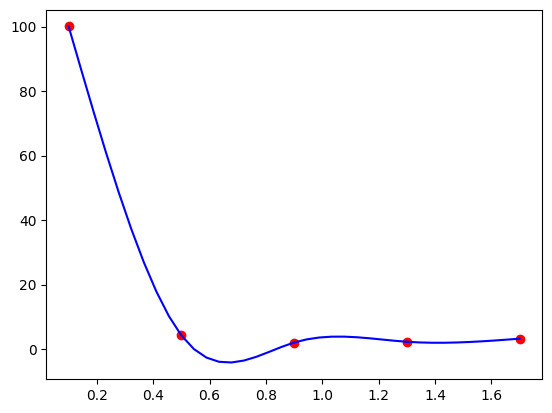

In [27]:
draw_plot(x_i, f_i, a, b, c, d)